In [1]:
# 1. Imports & Global configuration 
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from pathlib import Path
from requests import get
from functools import wraps
from collections import defaultdict
from libpysal.weights import Queen


DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR = DATA_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

CALENDAR_YMD = "20240614"
LISTINGS_YMD = "20250615"
CITY = "London"

HOST = "https://orca.casa.ucl.ac.uk"
ORCA_PATH = "~jreades/data"

# ORCA filenames
CALENDAR_FILE = RAW_DIR / f"{CALENDAR_YMD}-{CITY}-calendar.csv.gz"
LISTINGS_FILE = RAW_DIR / f"{LISTINGS_YMD}-{CITY}-listings.csv.gz"

In [2]:
# 2. cache helper
def check_cache(f):
    @wraps(f)
    def wrapper(src: str, dst_dir: Path, min_size: int = 100) -> Path:
        src0 = src.split("?")[0]
        fn = Path(src0).name
        dst = dst_dir / fn

        if dst.is_file() and dst.stat().st_size > min_size:
            print(f"+ {dst} found locally!")
            return dst
        else:
            print(f"+ {dst} not found, downloading!")
            return f(src, dst)
    return wrapper


@check_cache
def cache_data(src: str, dst: Path) -> Path:
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)

    with dst.open("wb") as f:
        r = get(src)
        r.raise_for_status()
        f.write(r.content)

    print("+ Done downloading.")
    return dst.resolve()

In [3]:
# 3. download/cache ORCA data
listings_url = f"{HOST}/{ORCA_PATH}/{LISTINGS_FILE.name}"
calendar_url = f"{HOST}/{ORCA_PATH}/{CALENDAR_FILE.name}"

listings_path = cache_data(listings_url, RAW_DIR)
calendar_path = cache_data(calendar_url, RAW_DIR)

+ data/raw/20250615-London-listings.csv.gz found locally!
+ data/raw/20240614-London-calendar.csv.gz found locally!


In [4]:
# 4. read listings
listings = pd.read_csv(listings_path)

print("Listings:", listings.shape)

Listings: (96651, 79)


In [5]:
# 5.read calendar by chunks
CHUNK_SIZE  = 200_000

def summarise_calendar_streaming(
    path: Path,
    chunk_size: int = CHUNK_SIZE,
    start_date: str = "2024-06-14",
    end_date: str   = "2025-06-14",
) -> pd.DataFrame:

    agg = {}  # {listing_id: [occupied_nights, total_nights]}

    for chunk in pd.read_csv(
        path,
        chunksize=chunk_size,
        usecols=["listing_id", "available", "date"],
        low_memory=False
    ):

        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
        chunk = chunk.dropna(subset=["date"])

        mask = (chunk["date"] >= start_date) & (chunk["date"] < end_date)
        chunk = chunk.loc[mask]
        if chunk.empty:
            continue

        chunk["is_occupied"] = (
            chunk["available"].astype(str).str.lower() == "f"
        )

        grouped = (
            chunk
            .groupby("listing_id")["is_occupied"]
            .agg(["sum", "count"])
            .reset_index()
        )

        for _, row in grouped.iterrows():
            lid = int(row["listing_id"])
            occ = int(row["sum"])
            tot = int(row["count"])

            if lid not in agg:
                agg[lid] = [0, 0]

            agg[lid][0] += occ
            agg[lid][1] += tot

    summary = (
        pd.DataFrame.from_dict(
            agg,
            orient="index",
            columns=["occupied_nights", "total_nights"]
        )
        .reset_index()
        .rename(columns={"index": "listing_id"})
    )

    summary["available_nights"] = (
        summary["total_nights"] - summary["occupied_nights"]
    )
    summary["occupancy_rate"] = (
        summary["occupied_nights"] / summary["total_nights"]
    )

    return summary
occ_summary = summarise_calendar_streaming(CALENDAR_FILE)
print(occ_summary.shape)
print(occ_summary.head())

(93480, 5)
   listing_id  occupied_nights  total_nights  available_nights  occupancy_rate
0       13913               34           364               330        0.093407
1       15400              202           364               162        0.554945
2       17402              100           363               263        0.275482
3       24328              363           363                 0        1.000000
4       33332                0           365               365        0.000000


In [6]:
# 6. thresholds / constants
VIOLATION_THRESHOLD        = 90
COMMERCIAL_AVAIL_THRESHOLD = 60
HOTEL_LIKE_OCC_THRESHOLD   = 180

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [7]:
# 7. Core wrangling helpers (used by Q1/Q2/Q3)
def load_listings(path: Path) -> pd.DataFrame:
    cols_in_file = pd.read_csv(path, nrows=0).columns.tolist()

    desired_cols = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price",
    ]
    usecols = [c for c in desired_cols if c in cols_in_file]

    df = pd.read_csv(path, usecols=usecols, low_memory=False)

    if "price" in df.columns:
        price_str = df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True)
        df["price_clean"] = pd.to_numeric(price_str, errors="coerce")
    else:
        df["price_clean"] = np.nan

    return df


def merge_calendar_listings(occ_summary: pd.DataFrame, listings: pd.DataFrame) -> pd.DataFrame:
    cols_to_keep = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price_clean",
    ]
    existing_cols = [c for c in cols_to_keep if c in listings.columns]

    merged = occ_summary.merge(
        listings[existing_cols].drop_duplicates(subset="id"),
        left_on="listing_id",
        right_on="id",
        how="left",
    )
    return merged


def add_core_flags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["is_entire_home"] = df["room_type"].eq("Entire home/apt")

    if not {"occupied_nights", "available_nights"}.issubset(df.columns):
        raise ValueError("缺少 occupied_nights 或 available_nights 列。")

    df["violates_90day"] = df["occupied_nights"] > VIOLATION_THRESHOLD
    df["commercial_STR"] = df["available_nights"] > COMMERCIAL_AVAIL_THRESHOLD
    df["hotel_like"]     = df["occupied_nights"] > HOTEL_LIKE_OCC_THRESHOLD

    df["legal_but_commercial"] = (~df["violates_90day"]) & df["commercial_STR"]
    return df


def prepare_merged(
    calendar_path: Path,
    listings_path: Path,
    start_date: str = "2024-06-14",
    end_date: str   = "2025-06-14",
) -> pd.DataFrame:
    print(f"=== Core Step: Summarising calendar {start_date} ~ {end_date} ===")
    occ_summary = summarise_calendar_streaming(
        calendar_path,
        chunk_size=CHUNK_SIZE,
        start_date=start_date,
        end_date=end_date,
    )
    print("  Listings with calendar data:", len(occ_summary))

    print("=== Core Step: Loading listings and merging ===")
    listings = load_listings(listings_path)
    merged = merge_calendar_listings(occ_summary, listings)
    merged = add_core_flags(merged)

    del occ_summary
    del listings

    print("  Total listings in merged:", merged["listing_id"].nunique())
    print("  Columns:", list(merged.columns))
    return merged


In [8]:
# 8. read calendar&listings，merge, flag
merged = prepare_merged(
    calendar_path=calendar_path,
    listings_path=listings_path
)

=== Core Step: Summarising calendar 2024-06-14 ~ 2025-06-14 ===
  Listings with calendar data: 93480
=== Core Step: Loading listings and merging ===
  Total listings in merged: 93480
  Columns: ['listing_id', 'occupied_nights', 'total_nights', 'available_nights', 'occupancy_rate', 'id', 'host_id', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'number_of_reviews', 'price_clean', 'is_entire_home', 'violates_90day', 'commercial_STR', 'hotel_like', 'legal_but_commercial']


In [9]:
# 9. 
BOROUGH_COL = "neighbourhood_cleansed"
print("merged shape:", merged.shape)
print("columns:", list(merged.columns)[:30], "...")

need_cols = ["listing_id", "occupied_nights", "available_nights", "room_type",
             "is_entire_home", "violates_90day", "commercial_STR", BOROUGH_COL]
for c in need_cols:
    print(f"{c}: ", "OK" if c in merged.columns else "MISSING")

if "room_type" in merged.columns:
    print("\nroom_type value counts (top 10):")
    print(merged["room_type"].value_counts(dropna=False).head(10))

if "is_entire_home" in merged.columns:
    print("\nis_entire_home counts:")
    print(merged["is_entire_home"].value_counts(dropna=False))

if BOROUGH_COL in merged.columns:
    print(f"\n{BOROUGH_COL} missing rate:", merged[BOROUGH_COL].isna().mean())
    print(f"{BOROUGH_COL} top 10:")
    print(merged[BOROUGH_COL].value_counts(dropna=False).head(10))


merged shape: (93480, 19)
columns: ['listing_id', 'occupied_nights', 'total_nights', 'available_nights', 'occupancy_rate', 'id', 'host_id', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'number_of_reviews', 'price_clean', 'is_entire_home', 'violates_90day', 'commercial_STR', 'hotel_like', 'legal_but_commercial'] ...
listing_id:  OK
occupied_nights:  OK
available_nights:  OK
room_type:  OK
is_entire_home:  OK
violates_90day:  OK
commercial_STR:  OK
neighbourhood_cleansed:  OK

room_type value counts (top 10):
room_type
Entire home/apt    40112
NaN                27929
Private room       25250
Hotel room           108
Shared room           81
Name: count, dtype: int64

is_entire_home counts:
is_entire_home
False    53368
True     40112
Name: count, dtype: int64

neighbourhood_cleansed missing rate: 0.29876979032948225
neighbourhood_cleansed top 10:
neighbourhood_cleansed
NaN                       27929
Westminster                6849
Towe

In [10]:
# 10.Policy

# entire-home
def _unique_entire_listings(df: pd.DataFrame) -> pd.DataFrame:
    out = df[df["is_entire_home"]].copy()
    out = out.drop_duplicates(subset="listing_id")
    return out


def citywide_violation_stats(df: pd.DataFrame) -> dict:
    entire = _unique_entire_listings(df)
    total_entire = entire["listing_id"].nunique()

    n_viol = int(entire["violates_90day"].sum())
    share_viol = n_viol / total_entire if total_entire > 0 else np.nan

    n_comm = int(entire["commercial_STR"].sum())
    share_comm = n_comm / total_entire if total_entire > 0 else np.nan

    overlap = int((entire["violates_90day"] & entire["commercial_STR"]).sum())
    overlap_rate = overlap / n_viol if n_viol > 0 else np.nan

    return {
        "total_entire_homes": int(total_entire),
        "n_violates_90day": int(n_viol),
        "share_violates_90day": share_viol,
        "n_commercial_entire": int(n_comm),
        "share_commercial_entire": share_comm,
        "overlap_count": int(overlap),
        "overlap_rate_within_violations": overlap_rate,
    }

def neighbourhood_violation_stats(df: pd.DataFrame) -> pd.DataFrame:
    entire = _unique_entire_listings(df)
    entire = entire.dropna(subset=[BOROUGH_COL]).copy()

    grouped = (
        entire
        .groupby(BOROUGH_COL)
        .agg(
            n_entire=("listing_id", "nunique"),
            n_violations=("violates_90day", "sum"),
            n_commercial=("commercial_STR", "sum"),
        )
        .reset_index()
        .rename(columns={BOROUGH_COL: "borough"})
    )

    grouped["share_violations"] = grouped["n_violations"] / grouped["n_entire"]
    grouped["share_commercial"] = grouped["n_commercial"] / grouped["n_entire"]

    return grouped

# Figure 1 
def plot_occupied_histogram(df: pd.DataFrame) -> None:
    entire = _unique_entire_listings(df)

    plt.figure()
    plt.hist(entire["occupied_nights"].dropna(), bins=30)
    plt.axvline(
        VIOLATION_THRESHOLD,
        color="red",
        linestyle="--",
        label="90-night limit"
    )
    plt.xlabel("Occupied nights (entire homes)")
    plt.ylabel("Number of listings")
    plt.title("Distribution of occupied nights (entire homes)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Figure 2
def plot_top_violation_areas(neigh_stats: pd.DataFrame, top_n: int = 20) -> None:
    df = neigh_stats.sort_values("share_violations", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["share_violations"])
    plt.gca().invert_yaxis()
    plt.xlabel("Share of entire homes violating 90-day rule")
    plt.ylabel("Borough")
    plt.title(f"Top {top_n} boroughs by 90-day rule violation rate")
    plt.tight_layout()
    plt.show()


# Figure 3 
def plot_share_commercial_vs_violations(neigh_stats: pd.DataFrame) -> None:
    df = neigh_stats.dropna(subset=["share_violations", "share_commercial"]).copy()
    if df.empty:
        print("No borough data，skip offset points.")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(df["share_violations"], df["share_commercial"])

    for _, row in df.iterrows():
        plt.annotate(
            row["borough"],
            (row["share_violations"], row["share_commercial"]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
        )

    plt.xlabel("Share of 90-day violations (entire homes)")
    plt.ylabel("Share of commercial STR (entire homes)")
    plt.title("Commercial STR vs 90-day violations by borough")
    plt.tight_layout()
    plt.show()


def run_policy_from_merged(merged: pd.DataFrame) -> dict:
    print("=== Policy: city-level stats ===")
    city_stats = citywide_violation_stats(merged)
    for k, v in city_stats.items():
        if isinstance(v, float):
            if "share" in k or "rate" in k:
                print(f"  {k}: {v:.2%}")
            else:
                print(f"  {k}: {v:.2f}")
        else:
            print(f"  {k}: {v}")

    print("\n=== Policy: borough-level stats ===")
    neigh_stats = neighbourhood_violation_stats(merged)
    print(neigh_stats.head())

    print("\n=== Figure 1 ===")
    plot_occupied_histogram(merged)

    print("\n=== Figure 2 ===")
    plot_top_violation_areas(neigh_stats, top_n=20)

    print("\n=== Figure 3 ===")
    plot_share_commercial_vs_violations(neigh_stats)

    print("\n=== Policy analysis done. ===")
    return {
        "city_stats": city_stats,
        "borough_stats": neigh_stats
    }


=== Policy: city-level stats ===
  total_entire_homes: 40112
  n_violates_90day: 33375
  share_violates_90day: 83.20%
  n_commercial_entire: 20330
  share_commercial_entire: 50.68%
  overlap_count: 13593
  overlap_rate_within_violations: 40.73%

=== Policy: borough-level stats ===
                borough  n_entire  n_violations  n_commercial  \
0  Barking and Dagenham       186           132           125   
1                Barnet       949           707           620   
2                Bexley       160           100           124   
3                 Brent      1054           882           580   
4               Bromley       303           239           183   

   share_violations  share_commercial  
0          0.709677          0.672043  
1          0.744995          0.653319  
2          0.625000          0.775000  
3          0.836812          0.550285  
4          0.788779          0.603960  

=== Figure 1 ===


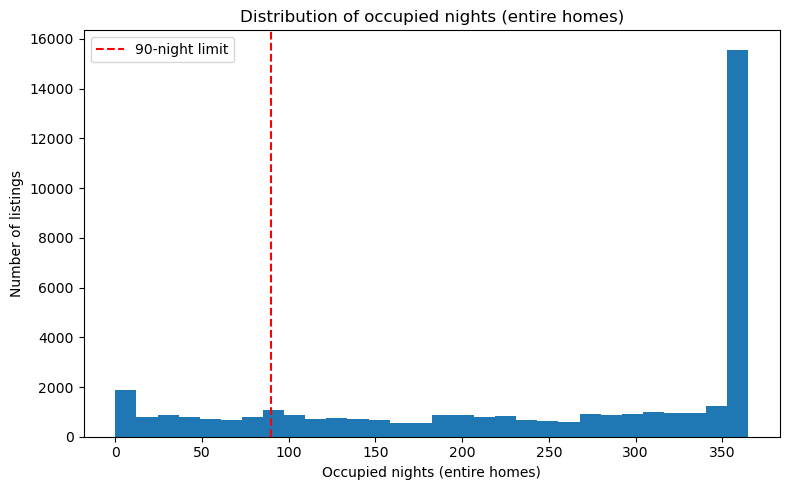


=== Figure 2 ===


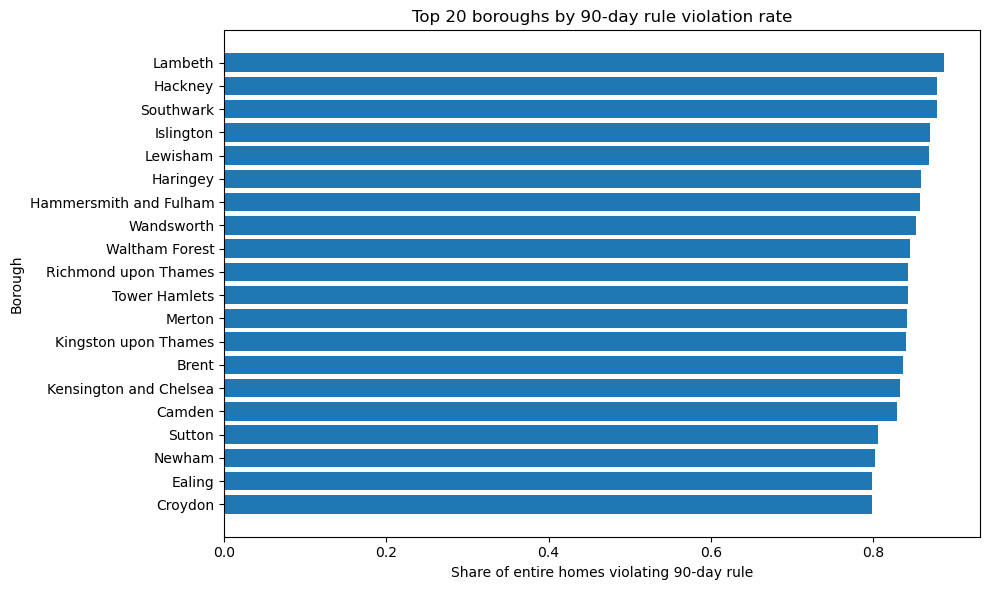


=== Figure 3 ===


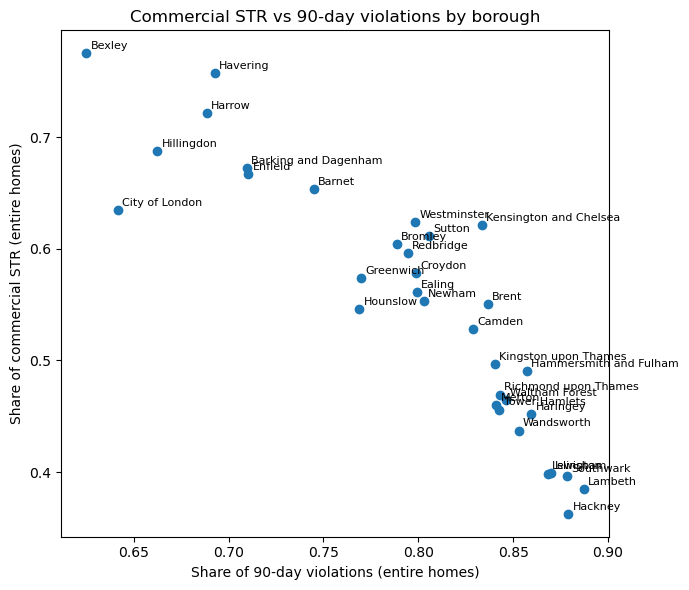


=== Policy analysis done. ===


In [11]:
# 11 Policy Result 
results_policy = run_policy_from_merged(merged)

In [12]:
# 6. group-provided borough data (local)

TABLE_DIR = DATA_DIR / "table"
TABLE_DIR.mkdir(parents=True, exist_ok=True)

RENT_EXCEL_PATH =TABLE_DIR / "borough_rent_2024_07_2025_06.xlsx"

if not RENT_EXCEL_PATH.exists():
    raise FileNotFoundError(f"Missing file: {RENT_EXCEL_PATH.resolve()}")

rent  = pd.read_excel(RENT_EXCEL_PATH)

print("Rent:", rent.shape)

Rent: (27, 1)


In [13]:
# 12 Commercial
def _unique_listings(df: pd.DataFrame) -> pd.DataFrame:
    if "listing_id" not in df.columns:
        raise ValueError("DataFrame 缺少 listing_id 列。")
    return df.drop_duplicates(subset="listing_id").copy()


def compute_entire_home_stats(df: pd.DataFrame) -> dict:
    d = _unique_listings(df)

    total_listings = d["listing_id"].nunique()
    entire = d[d["is_entire_home"]]
    n_entire = entire["listing_id"].nunique()
    share_entire = n_entire / total_listings if total_listings > 0 else np.nan

    return {
        "total_listings": int(total_listings),
        "n_entire": int(n_entire),
        "share_entire": share_entire,
    }


def compute_host_structure(df: pd.DataFrame) -> dict:
    d = _unique_listings(df)

    d = d.dropna(subset=["host_id"]).copy()

    host_counts = d.groupby("host_id")["listing_id"].nunique()
    total_hosts = int(host_counts.size)
    total_listings = int(d["listing_id"].nunique())

    n_multi_hosts = int((host_counts >= 2).sum())
    listing_by_multi = int(host_counts[host_counts >= 2].sum())

    stats = {
        "host_counts": host_counts,
        "total_hosts": total_hosts,
        "total_listings": total_listings,
        "n_multi_hosts": n_multi_hosts,
        "share_multi_hosts": (n_multi_hosts / total_hosts) if total_hosts > 0 else np.nan,
        "listing_by_multi": listing_by_multi,
        "share_listing_by_multi": (listing_by_multi / total_listings) if total_listings > 0 else np.nan,
    }
    return stats


def compute_availability_stats(df: pd.DataFrame) -> dict:
    """
    Availability-based STR categories (entire homes only):
      - commercial_STR / hotel_like / legal_but_commercial 这些 flag 已经在 merged 里打好
    """
    d = _unique_listings(df)
    entire = d[d["is_entire_home"]].copy()
    n_entire = int(entire["listing_id"].nunique())

    n_commercial = int(entire["commercial_STR"].sum())
    share_commercial = n_commercial / n_entire if n_entire > 0 else np.nan

    n_hotel_like = int(entire["hotel_like"].sum())
    share_hotel_like = n_hotel_like / n_entire if n_entire > 0 else np.nan

    n_legal_but_commercial = int(entire["legal_but_commercial"].sum())
    share_legal_but_comm = n_legal_but_commercial / n_entire if n_entire > 0 else np.nan

    return {
        "n_entire": n_entire,
        "n_commercial_entire": n_commercial,
        "share_commercial_entire": share_commercial,
        "n_hotel_like_entire": n_hotel_like,
        "share_hotel_like_entire": share_hotel_like,
        "n_legal_but_commercial_entire": n_legal_but_commercial,
        "share_legal_but_commercial_entire": share_legal_but_comm,
    }


#Figure 4.
def plot_host_distribution(host_structure_stats: dict, max_listings: int = 12) -> None:
    host_counts: pd.Series = host_structure_stats["host_counts"]
    vc = host_counts.value_counts().sort_index()

    vc_main = vc[vc.index <= max_listings].copy()
    others = int(vc[vc.index > max_listings].sum())

    if others > 0:
        vc_main.loc[max_listings + 1] = others
        labels = [str(i) for i in range(1, max_listings + 1)] + [f"{max_listings+1}+"]
        vc_main.index = labels
    else:
        vc_main.index = [str(i) for i in vc_main.index]

    plt.figure()
    vc_main.plot(kind="bar")
    plt.xlabel("Number of listings per host")
    plt.ylabel("Number of hosts")
    plt.title("Host size distribution (market structure)")
    plt.tight_layout()
    plt.show()


# Figure 5.
def plot_commercial_shares(avail_stats: dict) -> None:
    labels = [
        "Commercial STR (entire)",
        "Hotel-like STR (entire)",
        "Legal but commercial (entire)",
    ]
    values = [
        avail_stats["share_commercial_entire"],
        avail_stats["share_hotel_like_entire"],
        avail_stats["share_legal_but_commercial_entire"],
    ]

    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("Share of entire homes")
    plt.title("Availability-based STR categories")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


def run_commercial_from_merged(merged: pd.DataFrame) -> dict:
    """
    Commercial analysis (restricted):
      - Entire-home share (printed)
      - Host structure (printed)
      - Availability-based categories (printed)
      - Figures:
          C1 Host size distribution
          C2 Availability-based STR categories
    """
    print("=== Commercial: Entire-home share ===")
    entire_stats = compute_entire_home_stats(merged)
    print(entire_stats)

    print("\n=== Commercial: Host structure ===")
    host_stats = compute_host_structure(merged)
    print("Total hosts:", host_stats["total_hosts"])
    print("Multi-host share:", host_stats["share_multi_hosts"])
    print("Listings controlled by multi-hosts:", host_stats["share_listing_by_multi"])

    print("\n=== Commercial: Availability-based STR categories ===")
    avail_stats = compute_availability_stats(merged)
    for k, v in avail_stats.items():
        if k.startswith("share_"):
            print(f"{k}: {v:.2%}")
        else:
            print(f"{k}: {v}")

    print("\n=== Figure C1: Host size distribution ===")
    plot_host_distribution(host_stats, max_listings=12)

    print("\n=== Figure C2: Availability-based STR categories ===")
    plot_commercial_shares(avail_stats)

    print("\n=== Commercial analysis done . ===")
    return {
        "entire_stats": entire_stats,
        "host_stats": host_stats,
        "avail_stats": avail_stats,
    }

=== Commercial: Entire-home share ===
{'total_listings': 93480, 'n_entire': 40112, 'share_entire': 0.4290971330765939}

=== Commercial: Host structure ===
Total hosts: 43329
Multi-host share: 0.16704747397816705
Listings controlled by multi-hosts: 0.44942106146359323

=== Commercial: Availability-based STR categories ===
n_entire: 40112
n_commercial_entire: 20330
share_commercial_entire: 50.68%
n_hotel_like_entire: 27798
share_hotel_like_entire: 69.30%
n_legal_but_commercial_entire: 6737
share_legal_but_commercial_entire: 16.80%

=== Figure C1: Host size distribution ===


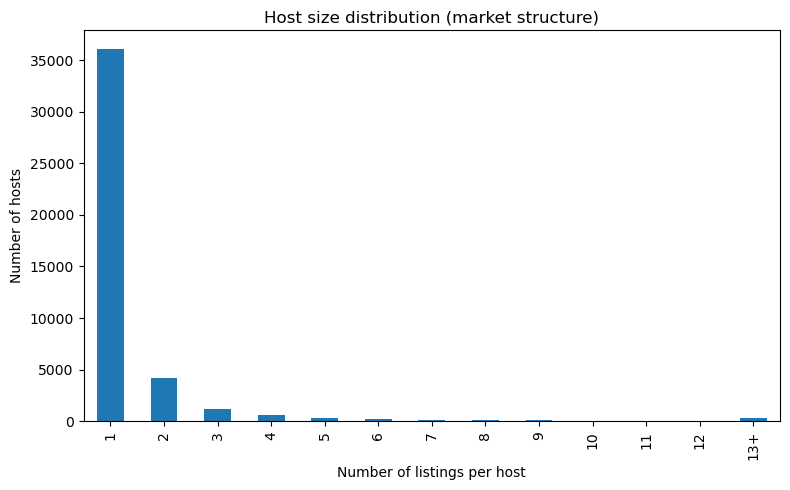


=== Figure C2: Availability-based STR categories ===


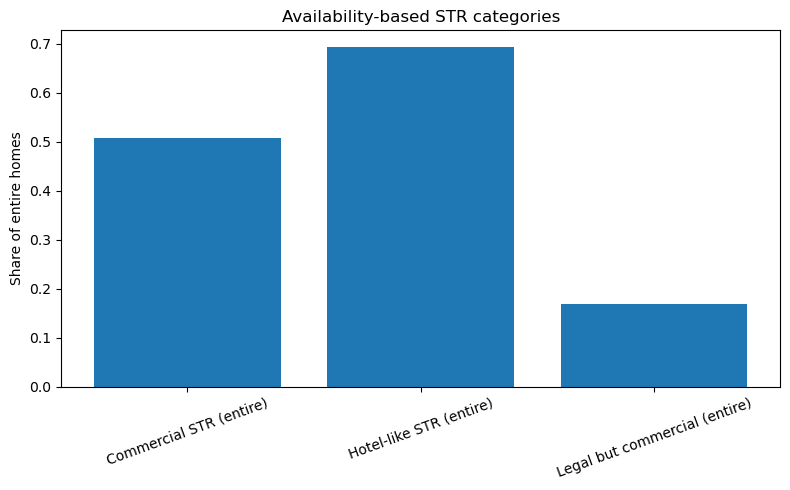


=== Commercial analysis done . ===


In [14]:
# 13 Commercial Result 
results_commercial = run_commercial_from_merged(merged)

In [15]:
# 14 Spatial Read 
GEO_DIR = DATA_DIR / "geo"
GEO_DIR.mkdir(parents=True, exist_ok=True)

url = "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Boroughs.gpkg"
out = GEO_DIR / "Boroughs.gpkg"

if not out.exists() or out.stat().st_size < 1000:
    print("Downloading Boroughs.gpkg ...")
    r = requests.get(url)
    r.raise_for_status()
    out.write_bytes(r.content)
else:
    print("Boroughs.gpkg already exists")

out

Boroughs.gpkg already exists


PosixPath('data/geo/Boroughs.gpkg')

In [16]:
# 15 

boros = gpd.read_file("data/geo/Boroughs.gpkg")
boros["borough"] = boros["NAME"].astype(str).str.strip().str.lower()

pts = gpd.GeoDataFrame(
    merged.copy(),
    geometry=gpd.points_from_xy(merged["longitude"], merged["latitude"]),
    crs="EPSG:4326"
)

pts = pts.to_crs(boros.crs)

pts_boro = gpd.sjoin(
    pts,
    boros[["borough", "geometry"]],
    how="left",
    predicate="within"  
)

pts_boro["borough"].isna().mean()
pts_boro[["listing_id","borough"]].head()


,listing_id,borough
0,13913,islington
1,15400,kensington and chelsea
2,17402,westminster
3,24328,wandsworth
4,33332,NaN


In [17]:
#16 Stock Read
borough_counts = (
    pts_boro.groupby("borough", as_index=False)
    .agg(
        n_listings=("listing_id", "nunique"),
        share_commercial_entire=("commercial_STR", "mean"),  # 如果你商业share定义不同，这里换成你的字段/逻辑
    )
)

In [18]:
#17 Stock Read
STOCK_CSV_PATH =TABLE_DIR /"social-landlord-housing-stock-borough.csv"

if not STOCK_CSV_PATH.exists():
    raise FileNotFoundError(f"Missing file:{STOCK_CSV_PATH.resolve()}")

stock = pd.read_csv(STOCK_CSV_PATH)

print("Stock:", stock.shape)
stock.head()
stock.columns
stock.dtypes

Stock: (46, 31)


Code                                                object
Area                                                object
Number of self-contained units-1997                 object
Number of self-contained units-1998                 object
Number of self-contained units-1999                 object
Number of self-contained units-2000                 object
Number of self-contained units-2001                 object
Number of self-contained units or bedspaces-2002    object
Number of self-contained units or bedspaces-2003    object
Number of self-contained units or bedspaces-2004    object
Number of self-contained units or bedspaces-2005    object
Number of self-contained units or bedspaces-2006    object
Number of self-contained units or bedspaces-2007    object
Number of self-contained units or bedspaces-2008    object
Number of self-contained units or bedspaces-2009    object
Number of self-contained units or bedspaces-2010    object
Number of self-contained units or bedspaces-2011    obje

In [19]:
#18 Stock 
stock2 = stock.copy()
stock2["borough"] = stock2["Area"].astype(str).str.strip().str.lower()

dwell_col = "Number of self-contained units or bedspaces-2024"
print("Using dwellings column:", dwell_col)

housing = stock2[["borough", dwell_col]].rename(
    columns={dwell_col: "dwellings"}
).copy()

housing["dwellings"] = (
    housing["dwellings"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

housing["dwellings"] = pd.to_numeric(
    housing["dwellings"],
    errors="coerce"
)

housing.head()

Using dwellings column: Number of self-contained units or bedspaces-2024


,borough,dwellings
0,nan,NaN
1,city of london,230.0
2,barking and dagenham,5582.0
3,barnet,10247.0
4,bexley,14175.0



=== Map 1: STR density choropleth ===


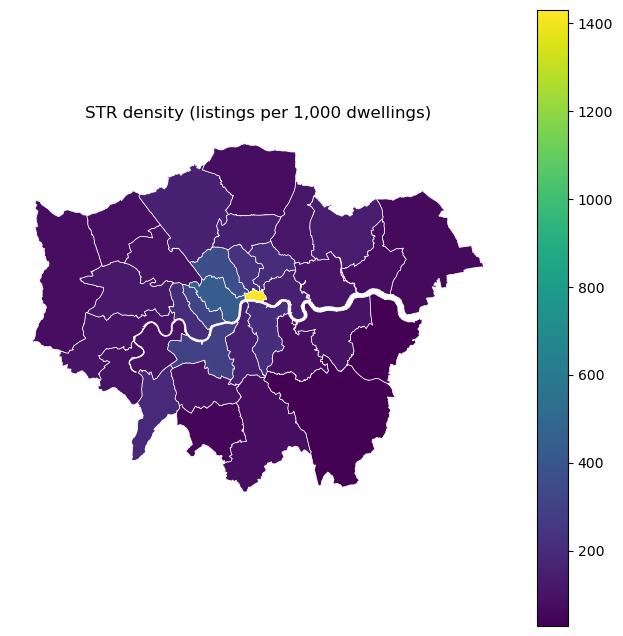

In [20]:
#19 
density_df = borough_counts.merge(housing, on="borough", how="left")
density_df["str_density_per_1000"] = density_df["n_listings"] / density_df["dwellings"] * 1000

print("\n=== Map 1: STR density choropleth ===")
boros_density = boros.merge(
    density_df[["borough", "str_density_per_1000"]],
    on="borough",
    how="left"
)

ax = boros_density.plot(
    column="str_density_per_1000",
    legend=True,
    figsize=(8, 8),
    edgecolor="white",
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

ax.set_axis_off()
ax.set_title("STR density (listings per 1,000 dwellings)")
plt.show()


In [21]:
# 20
pts = gpd.GeoDataFrame(
    merged.copy(),
    geometry=gpd.points_from_xy(merged["longitude"], merged["latitude"]),
    crs="EPSG:4326"
).to_crs(boros.crs)

pts_boro = gpd.sjoin(
    pts,
    boros[["borough", "geometry"]],
    how="left",
    predicate="within"
).dropna(subset=["borough"]).copy()
pts_boro["commercial_STR"] = pts_boro["commercial_STR"].astype(bool)

borough_counts = (
    pts_boro
    .groupby("borough", as_index=False)
    .agg(
        n_total=("listing_id", "nunique"),
        n_commercial=("commercial_STR", "sum")
    )
)

borough_counts["commercial_share"] = (
    borough_counts["n_commercial"] / borough_counts["n_total"]
)

borough_counts.head()



,borough,n_total,n_commercial,commercial_share
0,barking and dagenham,419,274,0.653938
1,barnet,1604,990,0.617207
2,bexley,406,301,0.741379
3,brent,1918,1075,0.560480
4,bromley,606,379,0.625413



=== Map 2: Commercial STR share by borough ===


(np.float64(500648.735),
 np.float64(564876.965),
 np.float64(153596.645),
 np.float64(203188.055))

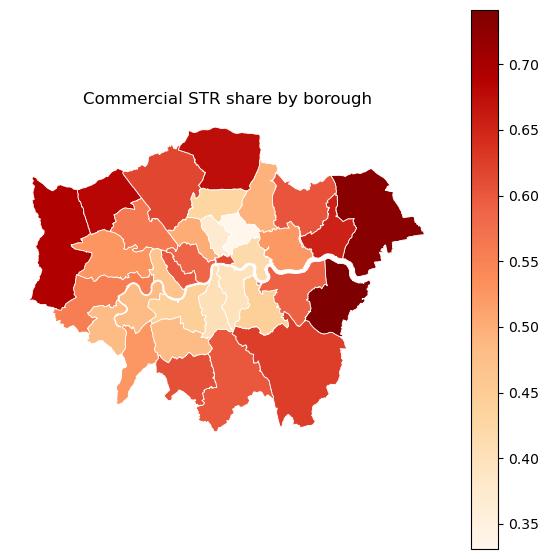

In [22]:
#21
boros_comm = boros.merge(
    borough_counts[["borough", "commercial_share"]],
    on="borough",
    how="left"
)
ax = boros_comm.plot(
    column="commercial_share",
    cmap="OrRd",
    legend=True,
    linewidth=0.6,
    edgecolor="white",
    figsize=(7, 7)
)

print("\n=== Map 2: Commercial STR share by borough ===")
ax.set_title("Commercial STR share by borough")
ax.axis("off")


In [23]:
# 22
gdf = boros_density[["geometry", "str_density_per_1000"]].copy()
gdf = gdf.dropna(subset=["str_density_per_1000"]).reset_index(drop=True)

y = gdf["str_density_per_1000"].to_numpy(dtype=float)
z = (y - y.mean()) / y.std(ddof=1)  # z-score

# 2) Queen 邻接权重（Practical 7 风格）
w = Queen.from_dataframe(gdf, use_index=False)
w.transform = "R"  # row-standardised

# 3) 计算 Global Moran's I
n = len(z)
S0 = w.s0
Wz = w.sparse @ z
I_obs = (n / S0) * (z @ Wz) / (z @ z)

print(f"Global Moran's I (observed): {I_obs:.4f}")

# 4) permutation test（双尾）
perms = 999
I_perm = np.empty(perms)

rng = np.random.default_rng(42)
for p in range(perms):
    z_perm = rng.permutation(z)
    Wz_perm = w.sparse @ z_perm
    I_perm[p] = (n / S0) * (z_perm @ Wz_perm) / (z_perm @ z_perm)

p_two = (np.sum(np.abs(I_perm) >= np.abs(I_obs)) + 1) / (perms + 1)
print(f"Permutation p-value (two-sided, {perms} perms): {p_two:.4f}")


Global Moran's I (observed): 0.2037
Permutation p-value (two-sided, 999 perms): 0.0030


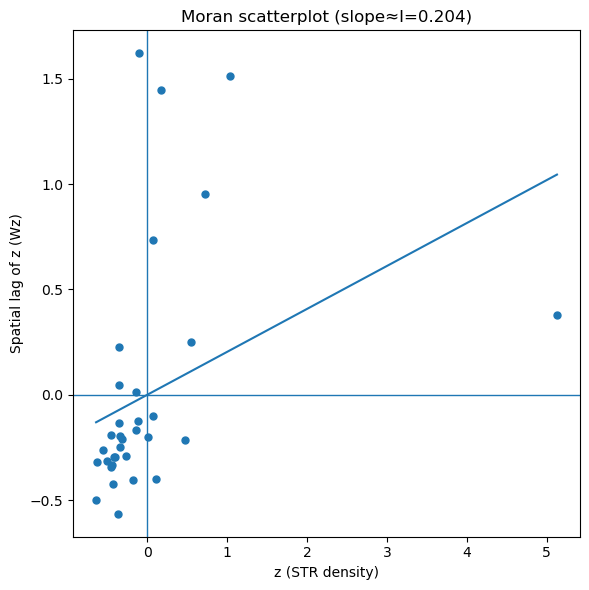

In [24]:
#23
# Moran scatterplot: z vs spatial lag of z
lag_z = Wz  # already row-standardised weights

plt.figure(figsize=(6,6))
plt.scatter(z, lag_z, s=25)
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

# 回归线（斜率≈Moran's I）
b = np.polyfit(z, lag_z, 1)[0]
xs = np.array([z.min(), z.max()])
plt.plot(xs, b*xs)

plt.xlabel("z (STR density)")
plt.ylabel("Spatial lag of z (Wz)")
plt.title(f"Moran scatterplot (slope≈I={I_obs:.3f})")
plt.tight_layout()


In [25]:
#25
ax = gdf_lisa.plot(
    column="cluster",
    categorical=True,
    legend=True,
    edgecolor="white",
    linewidth=0.8,y
    figsize=(8,8)
)
print("\n=== Map 3:Local Moran's I (LISA) clusters for STR density (p≤0.05 ===")
ax.set_title("Local Moran's I (LISA) clusters for STR density (p≤0.05)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (4006265576.py, line 7)